# Imports

In [4]:
import pandas as pd
from datetime import datetime
from datetime import timedelta
%matplotlib inline
%reload_ext watermark
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import numpy as np
import seaborn as sb
from IPython.display import display
from sklearn.neighbors import KNeighborsRegressor
import sklearn as sk
import sklearn.neural_network as sknn
from sklearn.model_selection import train_test_split



# Data

In this section we load both datasets we use, COVID-19 dataset and countries population dataset , clean the data and add some new columns.  

The datasets we use are:

* https://www.kaggle.com/imdevskp/corona-virus-report for the COVID-19 dataset

* https://www.kaggle.com/tanuprabhu/population-by-country-2020 for population information per country


## COVID-19 Dataset

In [5]:
# Loading datasets

full_table = pd.read_csv('datasets/covid_19_clean_complete.csv', 
                          na_values=['NaN'],
                          parse_dates=['Date'])

# Adding Active cases column
full_table['Active'] = (full_table['Confirmed'] - full_table['Deaths'] - full_table['Recovered']).apply(lambda x: x if x >= 0 else 0)

# filling missing values
full_table[['Province/State']] = full_table[['Province/State']].fillna('')
full_table[['Confirmed','Deaths','Recovered','Active']] = full_table[['Confirmed','Deaths','Recovered','Active']].fillna(0)

full_table.sample(6)


,Province/State,Country/Region,Lat,Long,Date,Confirmed,Deaths,Recovered,Active
24565,,Qatar,25.3548,51.1839,2020-04-23,7764,10,750,7004
1912,Hainan,China,19.1959,109.7453,2020-01-29,43,1,0,42
5309,New South Wales,Australia,-33.8688,151.2093,2020-02-11,4,0,2,2
3969,,Western Sahara,24.2155,-12.8858,2020-02-05,0,0,0,0
1144,,Congo (Kinshasa),-4.0383,21.7587,2020-01-26,0,0,0,0
8262,,Chad,15.4542,18.7322,2020-02-22,0,0,0,0


## Population Dataset


In [6]:
pop_table = pd.read_csv('datasets/population_by_country_2020.csv',
                        na_values=['N.A.'])


# Selecting only the Country and Population columns
pop_table = pop_table.iloc[:,[0,1,4,9]]



# Renaming columns
pop_table.columns = ['Country/Region', 'Population', 'Population Density (P/Km²)','Urban Population %']

# Most of the entries with urban population as NaN in the population dataset that we are going to use have 100% as of 2020
pop_table[['Urban Population %']] = pop_table[['Urban Population %']].fillna('100 %')
pop_table['Urban Population %'] = pop_table['Urban Population %'].map(lambda x: int(x.split(' ')[0]))


In [7]:
pop_table.info()
pop_table.isna().sum()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 235 entries, 0 to 234
Data columns (total 4 columns):
 #   Column                      Non-Null Count  Dtype 
---  ------                      --------------  ----- 
 0   Country/Region              235 non-null    object
 1   Population                  235 non-null    int64 
 2   Population Density (P/Km²)  235 non-null    int64 
 3   Urban Population %          235 non-null    int64 
dtypes: int64(3), object(1)
memory usage: 7.5+ KB


Country/Region                0
Population                    0
Population Density (P/Km²)    0
Urban Population %            0
dtype: int64

## Removing ship data

The dataset also includes data from the various ships that had COVID19 outbreaks. Since we only need the information per country we removed it from the dataset.

In [8]:
# ship rows
ship_rows = full_table['Province/State'].str.contains('Grand Princess') | full_table['Province/State'].str.contains('Diamond Princess') | full_table['Country/Region'].str.contains('Diamond Princess') | full_table['Country/Region'].str.contains('MS Zaandam')

# ship
ship = full_table[ship_rows]

# dropping ship rows 
full_table = full_table[~(ship_rows)]

ship.sample(6)


,Province/State,Country/Region,Lat,Long,Date,Confirmed,Deaths,Recovered,Active
26272,Grand Princess,Canada,37.6489,-122.6655,2020-04-30,13,0,0,13
23021,Diamond Princess,Canada,0.0000,0.0000,2020-04-17,0,1,0,0
17456,Diamond Princess,Canada,0.0000,0.0000,2020-03-27,0,1,0,0
231,Diamond Princess,Canada,0.0000,0.0000,2020-01-22,0,0,0,0
3798,,Diamond Princess,0.0000,0.0000,2020-02-05,0,0,0,0
4206,Diamond Princess,Canada,0.0000,0.0000,2020-02-06,0,0,0,0


## Fixing country names


### Fixing mismatched names between datasets

Here we manually set the names so that the join between datasets works.


In [9]:
fix_name_only = {
    'Sao Tome & Principe': 'Sao Tome and Principe',
    "Côte d'Ivoire": "Cote d'Ivoire",
    "United States": "US",
    "Czech Republic (Czechia)": 'Czechia',
    'Myanmar': 'Burma',
    'Taiwan': 'Taiwan*',
    'Saint Kitts & Nevis': 'Saint Kitts and Nevis',
    'Macao' : 'Macau'
}

for original,new in fix_name_only.items():
    full_table.loc[full_table['Country/Region'] == new, 'Country/Region'] = original
    full_table.loc[full_table['Province/State'] == new, 'Province/State'] = original

missing_countries = set(full_table['Country/Region']).difference(set(pop_table['Country/Region']))

# # print(sorted(pop_table['Country/Region'].unique()))
# if len(missing_countries) != 0:
#     print(missing_countries)


### Replacing Country/Region with Province/State

The population dataset has entries for autonomous regions, for example Greenland. Here we rewrite the Country/Region column with the Province/State name so we can easily join the population dataset. For example, Greenland exists in the population dataset so what we do is replace Denmark (the Country column of Greenland) with Greenland.

In [10]:

province_set = set(full_table['Province/State']).intersection(set(pop_table['Country/Region']))

no_data = set(['Saint Vincent and the Grenadines','Kosovo','Congo','West Bank and Gaza'])

for province in province_set:
    if province in no_data:
        continue
    full_table.loc[ full_table['Province/State'] == province,'Country/Region'] = province 



In [11]:
# Check for null values
full_table.isna().sum()

Province/State    0
Country/Region    0
Lat               0
Long              0
Date              0
Confirmed         0
Deaths            0
Recovered         0
Active            0
dtype: int64

## Grouping data

Here we are grouping data by Date and Country so we can add population and cases per million afterwards.

### Group by Country

In [12]:
full_grouped = full_table.groupby(['Country/Region','Lat','Long','Date'])['Confirmed','Deaths','Recovered','Active'].sum().reset_index()
# full_grouped = full_table.groupby(['Country/Region','Date'])['Confirmed','Deaths','Recovered','Active'].sum().reset_index()

full_grouped.head()

,Country/Region,Lat,Long,Date,Confirmed,Deaths,Recovered,Active
0,Afghanistan,33.0,65.0,2020-01-22,0,0,0,0
1,Afghanistan,33.0,65.0,2020-01-23,0,0,0,0
2,Afghanistan,33.0,65.0,2020-01-24,0,0,0,0
3,Afghanistan,33.0,65.0,2020-01-25,0,0,0,0
4,Afghanistan,33.0,65.0,2020-01-26,0,0,0,0


### Adding population
In this section, we merge both datasets by Country/Region.

In [13]:
full_grouped = pd.merge(full_grouped,pop_table,on=['Country/Region'])

full_grouped

,Country/Region,Lat,Long,Date,Confirmed,Deaths,Recovered,Active,Population,Population Density (P/Km²),Urban Population %
0,Afghanistan,33.0,65.0,2020-01-22,0,0,0,0,38742911,60,25
1,Afghanistan,33.0,65.0,2020-01-23,0,0,0,0,38742911,60,25
2,Afghanistan,33.0,65.0,2020-01-24,0,0,0,0,38742911,60,25
3,Afghanistan,33.0,65.0,2020-01-25,0,0,0,0,38742911,60,25
4,Afghanistan,33.0,65.0,2020-01-26,0,0,0,0,38742911,60,25
...,...,...,...,...,...,...,...,...,...,...,...
30971,Zimbabwe,-20.0,30.0,2020-05-17,44,4,17,23,14818157,38,38
30972,Zimbabwe,-20.0,30.0,2020-05-18,46,4,18,24,14818157,38,38
30973,Zimbabwe,-20.0,30.0,2020-05-19,46,4,18,24,14818157,38,38
30974,Zimbabwe,-20.0,30.0,2020-05-20,48,4,18,26,14818157,38,38


### World Data

In [14]:
world_data = full_grouped.groupby(['Date'])['Confirmed','Deaths','Recovered','Active','Population'].sum().reset_index()
world_data.loc[world_data['Date'] == world_data['Date'].max()]
world_data.head()

,Date,Confirmed,Deaths,Recovered,Active,Population
0,2020-01-22,555,17,28,510,51733396749
1,2020-01-23,654,18,30,606,51733396749
2,2020-01-24,941,26,35,880,51733396749
3,2020-01-25,1434,42,38,1354,51733396749
4,2020-01-26,2118,56,51,2011,51733396749


In [15]:
# Check information on types and null values
full_grouped.info()
full_grouped.loc[full_grouped['Urban Population %'].isnull()]['Country/Region'].unique()


<class 'pandas.core.frame.DataFrame'>
Int64Index: 30976 entries, 0 to 30975
Data columns (total 11 columns):
 #   Column                      Non-Null Count  Dtype         
---  ------                      --------------  -----         
 0   Country/Region              30976 non-null  object        
 1   Lat                         30976 non-null  float64       
 2   Long                        30976 non-null  float64       
 3   Date                        30976 non-null  datetime64[ns]
 4   Confirmed                   30976 non-null  int64         
 5   Deaths                      30976 non-null  int64         
 6   Recovered                   30976 non-null  int64         
 7   Active                      30976 non-null  int64         
 8   Population                  30976 non-null  int64         
 9   Population Density (P/Km²)  30976 non-null  int64         
 10  Urban Population %          30976 non-null  int64         
dtypes: datetime64[ns](1), float64(2), int64(7), object(1)


array([], dtype=object)

In [16]:
full_grouped.sample(6)

,Country/Region,Lat,Long,Date,Confirmed,Deaths,Recovered,Active,Population,Population Density (P/Km²),Urban Population %
10351,China,41.1129,85.2401,2020-03-28,76,3,73,0,1438207241,153,61
17175,Iran,32.0000,53.0000,2020-05-15,116635,6902,91836,17897,83771587,52,76
11446,Cuba,22.0000,-80.0000,2020-04-03,269,6,15,248,11327988,106,78
18087,Jordan,31.2400,36.5100,2020-03-20,85,0,1,84,10182442,115,91
30539,Western Sahara,24.2155,-12.8858,2020-03-09,0,0,0,0,594215,2,87
7504,China,24.9740,101.4870,2020-01-24,5,0,0,5,1438207241,153,61


### Calculating Cases per Million of People




In [17]:

def calc_permillion(df):
    df['Confirmed per million'] = round((df['Confirmed'] / df['Population']) * 1000000)
    df['Deaths per million']    = round((df['Deaths'] / df['Population']) * 1000000)
    df['Recovered per million'] = round((df['Recovered'] / df['Population']) * 1000000)
    df['Active per million']    = round((df['Active'] / df['Population']) * 1000000)
    return df


per_million = calc_permillion(full_grouped)

per_million.head()

,Country/Region,Lat,Long,Date,Confirmed,Deaths,Recovered,Active,Population,Population Density (P/Km²),Urban Population %,Confirmed per million,Deaths per million,Recovered per million,Active per million
0,Afghanistan,33.0,65.0,2020-01-22,0,0,0,0,38742911,60,25,0.0,0.0,0.0,0.0
1,Afghanistan,33.0,65.0,2020-01-23,0,0,0,0,38742911,60,25,0.0,0.0,0.0,0.0
2,Afghanistan,33.0,65.0,2020-01-24,0,0,0,0,38742911,60,25,0.0,0.0,0.0,0.0
3,Afghanistan,33.0,65.0,2020-01-25,0,0,0,0,38742911,60,25,0.0,0.0,0.0,0.0
4,Afghanistan,33.0,65.0,2020-01-26,0,0,0,0,38742911,60,25,0.0,0.0,0.0,0.0


### Value Truncation

Since the COVID-19 dataset only has data from  22nd of January of 2020 onwards, we will define Date from here moving foward as days since the 22nd of January of 2020.

In [18]:
per_million['Date'].min()

Timestamp('2020-01-22 00:00:00')

This function does that:

In [19]:
def daysSinceJan(d):
    return d.toordinal() - datetime(2020,1,20).toordinal()

def revertdaysSince(d):
    return datetime(2020,1,20) + timedelta(days=d)

In [20]:
per_million['Date'] = per_million['Date'].map(daysSinceJan)

In [21]:
per_million =  per_million.sort_values(['Date','Country/Region'],ascending=[True, True])
per_million.head()

,Country/Region,Lat,Long,Date,Confirmed,Deaths,Recovered,Active,Population,Population Density (P/Km²),Urban Population %,Confirmed per million,Deaths per million,Recovered per million,Active per million
0,Afghanistan,33.0000,65.0000,2,0,0,0,0,38742911,60,25,0.0,0.0,0.0,0.0
121,Albania,41.1533,20.1683,2,0,0,0,0,2878420,105,63,0.0,0.0,0.0,0.0
242,Algeria,28.0339,1.6596,2,0,0,0,0,43685618,18,73,0.0,0.0,0.0,0.0
363,Andorra,42.5063,1.5218,2,0,0,0,0,77240,164,88,0.0,0.0,0.0,0.0
484,Angola,-11.2027,17.8739,2,0,0,0,0,32644783,26,67,0.0,0.0,0.0,0.0


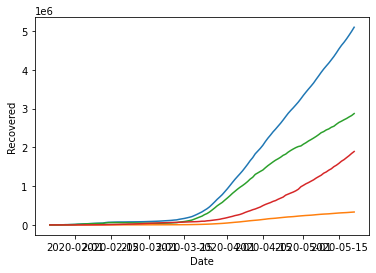

In [22]:
sb.lineplot(x='Date',y='Confirmed',data=world_data)
sb.lineplot(x='Date',y='Deaths',data=world_data)
sb.lineplot(x='Date',y='Active',data=world_data)
sb.lineplot(x='Date',y='Recovered',data=world_data)

In [23]:
per_million.head()

,Country/Region,Lat,Long,Date,Confirmed,Deaths,Recovered,Active,Population,Population Density (P/Km²),Urban Population %,Confirmed per million,Deaths per million,Recovered per million,Active per million
0,Afghanistan,33.0000,65.0000,2,0,0,0,0,38742911,60,25,0.0,0.0,0.0,0.0
121,Albania,41.1533,20.1683,2,0,0,0,0,2878420,105,63,0.0,0.0,0.0,0.0
242,Algeria,28.0339,1.6596,2,0,0,0,0,43685618,18,73,0.0,0.0,0.0,0.0
363,Andorra,42.5063,1.5218,2,0,0,0,0,77240,164,88,0.0,0.0,0.0,0.0
484,Angola,-11.2027,17.8739,2,0,0,0,0,32644783,26,67,0.0,0.0,0.0,0.0


# Model Training

## Inputs and outputs

This function will return a pair of inputs and outputs given the country:

In [24]:
def world_train_data(df_full,country=None):
    df = df_full
    input  = ['Date','Population Density (P/Km²)','Urban Population %','Lat','Long']
    if country is not None:
        df = df_full.loc[ df_full['Country/Region'] == country]
        input = ['Date']
    return df[input], df[['Confirmed per million',	'Deaths per million',	'Recovered per million']]


In [25]:
# X,Y = world_train_data(per_million)

# X = X.values
# Y = Y.values


# nn = sknn.MLPRegressor(
#     hidden_layer_sizes=(20,50,20,100,20,50,20),
#     activation='relu',
#     solver='adam',
#     alpha=0.00001,
#     batch_size='auto',
#     max_iter = 100000,
#     n_iter_no_change=201,
#     verbose=True,
#     )

# X_train, X_test, y_train, y_test = train_test_split(X,Y,test_size=0.30,shuffle=True)


# nn.fit(X_train,y_train) # Train the model
# nn.score(X_test,y_test) # Calculate R² for the model


In [26]:
per_million.loc[per_million['Country/Region'] == 'Portugal']['Population Density (P/Km²)'].unique()
per_million.loc[per_million['Country/Region'] == 'Portugal']['Urban Population %'].unique()
per_million.loc[per_million['Country/Region'] == 'Portugal']['Long'].unique()
per_million.loc[per_million['Country/Region'] == 'Portugal']['Lat'].unique()


array([39.3999])

In [27]:
def print_graph(world_viz):
    things = ['Confirmed','Deaths','Recovered']
    dd = world_viz.melt(['Date'],var_name='C/D/R', value_name='Cases',value_vars=things)


    chart = sb.relplot(x='Date',y='Cases',hue='C/D/R',data=dd,kind='line')

    axs = chart.axes

    days = mdates.DayLocator(interval=9)
    months = mdates.MonthLocator()  # every month
    days_fmt = mdates.DateFormatter('%d-%b')

    for ax in axs[0]:
        ax.xaxis.set_major_locator(months)
        ax.xaxis.set_major_formatter(days_fmt)
        ax.xaxis.set_minor_locator(days)

        ax.format_xdata = mdates.DateFormatter('%Y-%m-%d')
        ax.grid(True)


In [28]:


# ip = []
# for dat in range(0,125+30): # Predict from 0 to 155 days from January 1st 2020
#     ip.append([dat,111,66,39.3999,-8.2245]) # Hard Coded Pop Density, Urban Pop %, Latitude and Longitude

# out = nn.predict(ip)

# nl = []

# for i,o in zip(ip,out):
#     nl.append([*i,*o])

# predict = pd.DataFrame(nl,columns=['Date','Population Density (P/Km²)','Urban Population %','Lat','Long','Confirmed','Deaths','Recovered'])


# predict['Date'] = predict['Date'].map(revertdaysSince) 
# predict['Confirmed'] = predict['Confirmed'].map(lambda x: round((x/1000000) * 10202571))
# predict['Recovered'] = predict['Recovered'].map(lambda x: round((x/1000000) * 10202571))
# predict['Deaths'] = predict['Deaths'].map(lambda x: round((x/1000000) * 10202571) )


# print_graph(predict)
# print_graph(full_grouped.loc[full_grouped['Country/Region'] == 'Portugal'])


## K-Nearest Neighbours
Apply KNN algorithm to regression modulation data.

#### Getting world data

In [29]:
p = calc_permillion(world_data)
X = p[['Date']]
Y = p[['Confirmed per million','Deaths per million','Recovered per million']]

#### Getting country data

In [35]:
X,Y = world_train_data(per_million, 'Portugal')

#### Applying the KNN regression algorithm

In [36]:
#X = X.values
#Y = Y.values

knn = KNeighborsRegressor()

X_train, X_test, y_train, y_test = train_test_split(X,Y,test_size=0.30,shuffle=True)

knn.fit(X_train,y_train)
knn.score(X_test,y_test)

0.9991834267451304

#### Retrieving column values for world data

When working with world data, it is only necessary to have date (days since January 1st 2020) as input.

In [37]:
ip = []
days = per_million['Date'].max()
for dat in range(0,days + 100): # Predict from 0 to 155 days from January 1st 2020
    ip.append([dat])

#### Retrieving column values by country

In case we are modeling data of a country, it is necessary to retrieve columns 'Population Density (P/Km²)','Urban Population %','Lat' and 'Long'.

In [42]:
per_million.loc[per_million['Country/Region'] == 'Portugal'].groupby(['Lat', 'Long','Population Density (P/Km²)','Urban Population %']).size()

ip = []
days = per_million['Date'].max()
for dat in range(0,days + 30): # Predict from 0 to 155 days from January 1st 2020
    ip.append([dat])


#### Predict

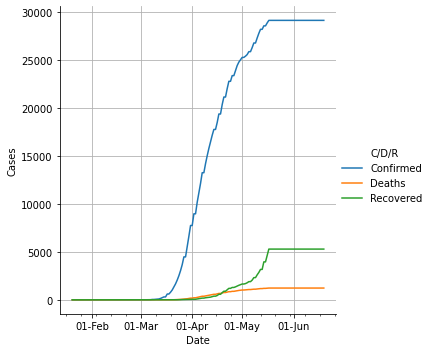

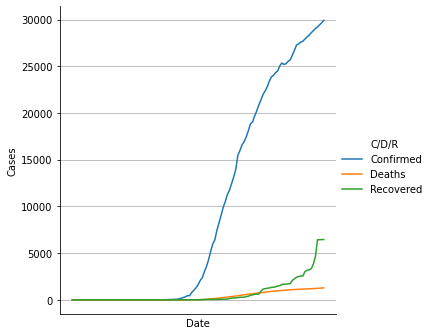

In [43]:
out = knn.predict(ip)

nl = []

for i,o in zip(ip,out):
    nl.append([*i,*o])

predict = pd.DataFrame(nl,columns=['Date','Confirmed','Deaths','Recovered'])

predict['Date'] = predict['Date'].map(revertdaysSince) 
predict['Confirmed'] = predict['Confirmed'].map(lambda x: round((x/1000000) * 10202571))
predict['Recovered'] = predict['Recovered'].map(lambda x: round((x/1000000) * 10202571))
predict['Deaths'] = predict['Deaths'].map(lambda x: round((x/1000000) * 10202571) )


print_graph(predict)
print_graph(full_grouped.loc[full_grouped['Country/Region'] == 'Portugal'])
